In [ ]:
/**********                         CHRISTMAS ANALYSIS (SQL SECTION FIRST)               **************


Author:       Angus Gair 
Reviewers:    
ProductOwner: Julie H
Last updated: 2024-10-16
Version:      1.01v

OBJECTIVE: 

        Optimise campaign offer based on budget and target groups

REQUIREMENTS:

            - similar historical campaigns
            - Size of intended auidence

KEY ASSUMPTIONS MADE:
    1. FIXED AUDIENCE SIZE 
      - Reactivation: 1,500,000
      - Priority: 1,200,000
        - We then break this into crest groups


THINGS TO NOTE:

    1. The current version of the model uses a exBoost model to learn redemption behaviour
    2. The model is trained on historical data and is used to predict redemption rates for future campaigns
    3. The model is trained on a dataset that includes the following features:
        - Customer Segment
        - Minimum Basket Spend
        - Points Value
        - Crest Group

    4. Model Selection
        - current model is xgBoostRession, this results in a "Lumpy" optimisation space
        - Purhaps a more linear model would be more appropriate as we are trying to capture how increasing points offered, increases redemption rates
            - Linear Regression: Generalised Additive Model (GAM) with smoothing function
            - Is supplied in the code, but not intergrated into the model

    5. Optimisation Algorithm
        - The current model uses a grid search to find the optimal points value
        - This is a brute force method and is not the most efficient
        - A more efficient method would be to use a bayesian optimisation algorythm or Linear Algebra

WARNINGS:
    - The optimisation process is sensitive to the audience size. If predicting outside of the training data, the model may not be accurate
    - resulting in redemtion rates that are flat.



****************************************************************************************************************************/

In [1]:
## switch to python to do the rest of the analysis

# required 
import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import StandardScaler
import pandas_gbq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:


# Initialize BigQuery client
client = bigquery.Client(project='gcp-wow-rwds-ai-pobe-dev')

# Query
sql = """
SELECT * 
FROM `gcp-wow-rwds-ai-pobe-dev.angus.bigw_xmas_modelData2` 
"""

# Execute query and get results as DataFrame
modelData = client.query(sql).to_dataframe()

# Dataset Summary

# 1. Column Headers
print("Column Headers:")
print(modelData.columns.tolist())

# 2. Data Types
print("\nData Types:")
print(modelData.dtypes)

# 3. Missing Values
print("\nMissing Values:")
print(modelData.isnull().sum())

# 4. Unique Values
print("\nUnique Values:")
print({col: modelData[col].nunique() for col in modelData.columns})

# 5. Summary Statistics
print("\nSummary Statistics:")
print(modelData.describe(include='all'))


# Display first few rows
print(modelData.head())



C:\Users\angus_6v2ij9a\AppData\Roaming\Python\Python312\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Column Headers:
['campaign_key', 'minimum_basket_spend', 'points_value', 'crest_groupname', 'OfferLevelEE', 'CustomerSegment', 'cost', 'Audience', 'Activations', 'Redeemer_flag', 'ActivationRate', 'RedemptionRate']

Data Types:
campaign_key             object
minimum_basket_spend    float64
points_value            float64
crest_groupname          object
OfferLevelEE             object
CustomerSegment          object
cost                     object
Audience                  Int64
Activations               Int64
Redeemer_flag             Int64
ActivationRate          float64
RedemptionRate          float64
dtype: object

Missing Values:
campaign_key              0
minimum_basket_spend      0
points_value              0
crest_groupname           0
OfferLevelEE              0
CustomerSegment           0
cost                    278
Audience                  0
Activations               0
Redeemer_flag             0
ActivationRate            0
RedemptionRate            0
dtype: int64

Unique 

In [3]:
modelData['ln_Audience'] = np.log(modelData['Audience'])

In [4]:
## transform xvars = ['Audience']

## Data a Preprocessing
xvars = ['minimum_basket_spend', 'points_value','CustomerSegment' , 'crest_groupname'] #, 'crest_groupname'
X = modelData[xvars]
y = modelData['RedemptionRate']


# Encode categorical features
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

## NO TEST TRAIN SPLIT

C:\Users\angus_6v2ij9a\AppData\Local\Temp\ipykernel_3504\3820135410.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
C:\Users\angus_6v2ij9a\AppData\Local\Temp\ipykernel_3504\3820135410.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])


In [5]:
# Train XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X, y)
y_pred = xgb_model.predict(X)
print("Predicted Values (Original Scale):", y_pred[:10])

Predicted Values (Original Scale): [0.01201288 0.01517469 0.02125846 0.00219244 0.14396966 0.01292695
 0.09745374 0.10371442 0.01582312 0.0914269 ]


In [6]:

# 1. Apply logarithmic transformation to the target variable
y_log_transformed = np.log(y + 1)  # Add 1 to avoid log(0), if necessary

# 2. Train XGBoost Regressor on the transformed target
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X, y_log_transformed)
#xgb_model.fit(X, y)

# 3. Make predictions
y_log_pred = xgb_model.predict(X)

#y_pred = xgb_model.predict(X)

# 4. Apply the inverse transformation to get predictions in the original scale
y_pred = np.exp(y_log_pred) - 1  # Subtract 1 if you added it during transformation

# Displaying some predicted values for review
print("Predicted Values (Original Scale):", y_pred[:10])

# Train XGBoost Regressor
#xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
#xgb_model.fit(X, y)

Predicted Values (Original Scale): [0.0120542  0.01512218 0.02130961 0.00244617 0.14194071 0.01285946
 0.09661448 0.10284579 0.01560497 0.09054756]


In [7]:
## Create a prediction set
# Generate all combinations of CustomerSegment and crest_groupname, points_value and minimum_basket_spend
df_CustomerSegment = pd.DataFrame({
    'CustomerSegment': ['Priority', 'Reactivate']
})

#df_Crest = pd.DataFrame({
#    'crest_groupname': ['crest_groupname'	'Refined'	'Essential'	'Unclassified'	'Savers'	'Conscious'	'Traditional']
#})
# Create a DataFrame for crest_groupname
df_crest_groupname = pd.DataFrame({
    'crest_groupname': ['Conscious', 'Unclassified', 'Essential', 'Traditional', 'Refined', 'Savers']
})


# Range of points_value and cost
df_points_value = np.arange(100, 3501, 5)


# Generate minimum_basket_spend ranging from 30 to 100 with increments of 10
df_minimum_basket_spend = np.arange(30, 151, 5)

# Create all possible combinations of the features

combinations = list(product(
    df_CustomerSegment['CustomerSegment'],
    df_crest_groupname['crest_groupname'],
    df_points_value,
    df_minimum_basket_spend
))

# Create a DataFrame from combinations
df_combinations = pd.DataFrame(combinations, columns=['CustomerSegment', 'crest_groupname', 'points_value', 'minimum_basket_spend']) #, '





In [8]:
# Create a DataFrame with the detailed segment data
list_audience_sizes = [
    ('Priority', 'Conscious', 152511),
    ('Priority', 'Essential', 124815),
    ('Priority', 'Refined', 83679),
    ('Priority', 'Savers', 410796),
    ('Priority', 'Traditional', 294266),
    ('Priority', 'Unclassified', 133929),
    ('Reactivate', 'Conscious', 201469),
    ('Reactivate', 'Essential', 183190),
    ('Reactivate', 'Refined', 152187),
    ('Reactivate', 'Savers', 246018),
    ('Reactivate', 'Traditional', 343725),
    ('Reactivate', 'Unclassified', 373409)
]
# Convert the list to a DataFrame
df_audience_sizes = pd.DataFrame(list_audience_sizes, columns=['CustomerSegment', 'crest_groupname', 'Audience'])



In [9]:

# create a low, medium and high points for audiuece size on the scale low: Size*0.8, high: Size*1.


# Create a dictionary for audience sizes with a tuple of (CustomerSegment, CrestGroupName) as the key
audience_sizes_dict = {
    (row['CustomerSegment'], row['crest_groupname']): row['Audience']
    for _, row in df_audience_sizes.iterrows()
}


In [10]:
# Map audience sizes to the CustomerSegment and CrestGroupName columns
df_combinations['Audience'] = df_combinations.apply(
    lambda row: audience_sizes_dict.get((row['CustomerSegment'], row['crest_groupname']), float('nan')),
    axis=1
)
df_combinations['ln_Audience'] = np.log(df_audience_sizes['Audience'])

# Encode categorical columns in the combinations DataFrame
for column in df_combinations.select_dtypes(include=['object']).columns:
    le = label_encoders[column]
    df_combinations[column] = le.transform(df_combinations[column])
    

In [11]:
# Predict redemption rates using the trained XGBoost model
#df_combinations['log_pred_RedemptionRate'] = xgb_model.predict(df_combinations[['minimum_basket_spend', 'points_value', 'CustomerSegment', 'crest_groupname']])
#df_combinations['pred_RedemptionRate'] = np.exp(df_combinations['log_pred_RedemptionRate']) - 1 

df_combinations['pred_RedemptionRate'] = (xgb_model.predict(df_combinations[['minimum_basket_spend', 'points_value', 'CustomerSegment', 'crest_groupname']]))

In [12]:

# Create a new column for predicted redeemers
df_combinations['pred_Redeemers'] = (df_combinations['pred_RedemptionRate']) * df_combinations['Audience']
# Create a new column for total cost
df_combinations['TotalCost'] = (df_combinations['points_value'] / 200) * df_combinations['pred_Redeemers']


In [13]:
# Predict Redemption Rates
# Audience sizes dictionary
#audience_sizes_dict = {
#    'Priority':  700000,
#    'Reactivate': 800000
#}
# Ensure the columns are in the same order as the training data
#df_combinations = df_combinations[['minimum_basket_spend', 'points_value', 'CustomerSegment', 'crest_groupname']]


# Display the first few rows of the prediction set
print(df_combinations.head())

# Convert back to original categorical values
for column, le in label_encoders.items():
    df_combinations[column] = le.inverse_transform(df_combinations[column])

   CustomerSegment  crest_groupname  points_value  minimum_basket_spend  \
0                0                0           100                    30   
1                0                0           100                    35   
2                0                0           100                    40   
3                0                0           100                    45   
4                0                0           100                    50   

   Audience  ln_Audience  pred_RedemptionRate  pred_Redeemers    TotalCost  
0    152511    11.934992             0.086680    13219.624319  6609.812160  
1    152511    11.734588             0.086680    13219.624319  6609.812160  
2    152511    11.334743             0.088106    13437.074916  6718.537458  
3    152511    12.925852             0.088106    13437.074916  6718.537458  
4    152511    12.592239             0.079874    12181.694514  6090.847257  


In [14]:
# Load the DataFrame back to BigQuery
table_id = 'gcp-wow-rwds-ai-pobe-dev.angus.bigw_xmas_predictions'
df_combinations.to_gbq(table_id, project_id='gcp-wow-rwds-ai-pobe-dev', if_exists='replace')

print("Predictions saved to BigQuery.")

C:\Users\angus_6v2ij9a\AppData\Local\Temp\ipykernel_3504\658395852.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_combinations.to_gbq(table_id, project_id='gcp-wow-rwds-ai-pobe-dev', if_exists='replace')
C:\Users\angus_6v2ij9a\AppData\Roaming\Python\Python312\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
100%|██████████| 1/1 [00:00<?, ?it/s]

Predictions saved to BigQuery.


In [15]:



# Pivot the table so that CustomerSegment becomes columns
pivot_table = df_combinations.pivot_table(
    index=['minimum_basket_spend', 'points_value'],
    columns='CustomerSegment',
    values=['Audience','pred_RedemptionRate', 'pred_Redeemers', 'TotalCost'],
    aggfunc={ 'Audience': 'sum', 'pred_RedemptionRate': 'mean', 'pred_Redeemers': 'sum', 'TotalCost': 'sum'}
)

# Flatten the multi-level column index
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]

# Reset index to make it flat
pivot_table.reset_index(inplace=True)

# Show the resulting pivot table
print(pivot_table)

       minimum_basket_spend  points_value  Audience_Priority  \
0                        30           100            1199996   
1                        30           105            1199996   
2                        30           110            1199996   
3                        30           115            1199996   
4                        30           120            1199996   
...                     ...           ...                ...   
17020                   150          3480            1199996   
17021                   150          3485            1199996   
17022                   150          3490            1199996   
17023                   150          3495            1199996   
17024                   150          3500            1199996   

       Audience_Reactivate  TotalCost_Priority  TotalCost_Reactivate  \
0                  1499998        5.808268e+04           8829.795560   
1                  1499998        6.098682e+04           9271.285338   
2              

In [16]:
# stripe out spaces in column names and replace with '_' for pivot_table
# add new columns to pivot_table TotalCost and TotalRedeemers as TotalCost =  TotalCost_Group_3_BIGW_Lapsed + TotalCost_Group_BIGW_Active
# do the same for TotalRedeemers

#pivot_table.columns = pivot_table.columns.str.replace(' ', '_')


# Add new columns for TotalCost and TotalRedeemers
pivot_table['TotalCost'] = pivot_table['TotalCost_Reactivate'] + pivot_table['TotalCost_Priority']
pivot_table['TotalRedeemers'] = pivot_table['pred_Redeemers_Priority'] + pivot_table['pred_Redeemers_Reactivate']
pivot_table['TotalAudience'] = pivot_table['Audience_Priority'] + pivot_table['Audience_Reactivate']
# Display the pivot table
print(pivot_table)

       minimum_basket_spend  points_value  Audience_Priority  \
0                        30           100            1199996   
1                        30           105            1199996   
2                        30           110            1199996   
3                        30           115            1199996   
4                        30           120            1199996   
...                     ...           ...                ...   
17020                   150          3480            1199996   
17021                   150          3485            1199996   
17022                   150          3490            1199996   
17023                   150          3495            1199996   
17024                   150          3500            1199996   

       Audience_Reactivate  TotalCost_Priority  TotalCost_Reactivate  \
0                  1499998        5.808268e+04           8829.795560   
1                  1499998        6.098682e+04           9271.285338   
2              

In [ ]:
## update value 

In [17]:
# Define the budget constraint
budget = 950000

# Define the upper and lower bounds for points_value and minimum_basket_spend
points_value_lower_bound = 1200
points_value_upper_bound = 3000
minimum_basket_spend_lower_bound = 10
minimum_basket_spend_upper_bound = 100

# Filter the combinations based on all constraints
filtered_df = pivot_table[
    (pivot_table['TotalCost'] < budget) &
    (pivot_table['points_value'] >= points_value_lower_bound) &
    (pivot_table['points_value'] <= points_value_upper_bound) &
    (pivot_table['minimum_basket_spend'] >= minimum_basket_spend_lower_bound) &
    (pivot_table['minimum_basket_spend'] <= minimum_basket_spend_upper_bound)
]

# Find the combination that maximizes TotalRedeemers
optimal_combination = filtered_df.loc[filtered_df['TotalRedeemers'].idxmax()]

# Display the optimal combination
print("Optimal Combination:")
# Format the numbers
formatted_combination = optimal_combination.copy()
for col in formatted_combination.index:
    if formatted_combination[col] >= 1:
        formatted_combination[col] = f"{formatted_combination[col]:,.0f}"
    else:
        formatted_combination[col] = f"{formatted_combination[col]:.3%}"

print(formatted_combination)

Optimal Combination:
minimum_basket_spend                     55
points_value                          1,400
Audience_Priority                 1,199,996
Audience_Reactivate               1,499,998
TotalCost_Priority                  639,914
TotalCost_Reactivate                114,770
pred_Redeemers_Priority              91,416
pred_Redeemers_Reactivate            16,396
pred_RedemptionRate_Priority         6.648%
pred_RedemptionRate_Reactivate       1.155%
TotalCost                           754,684
TotalRedeemers                      107,812
TotalAudience                     2,699,994
Name: 3665, dtype: object


C:\Users\angus_6v2ij9a\AppData\Local\Temp\ipykernel_3504\199222008.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '55' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_combination[col] = f"{formatted_combination[col]:,.0f}"


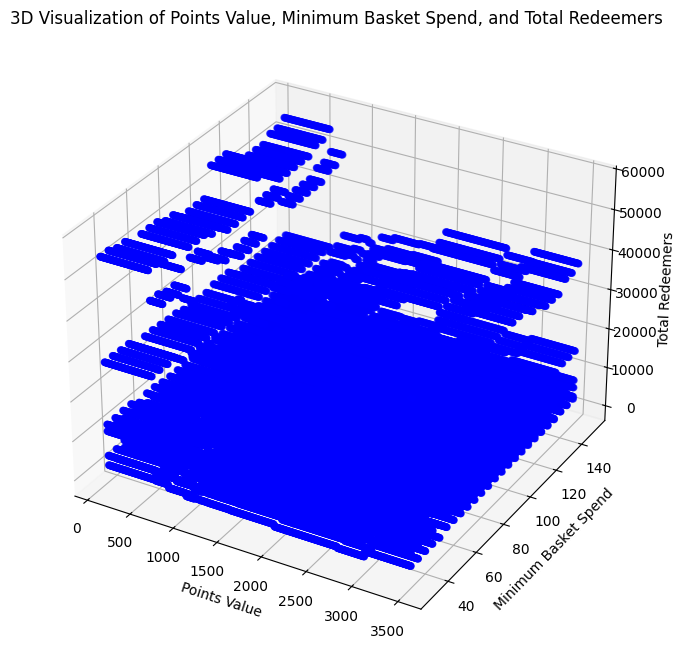

In [18]:
# Visualise df_combinations for points_value, minimum_basket_spend, TotalRedeemers in a single plot
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

filtered_df_comb = df_combinations[df_combinations['CustomerSegment'] == 'Priority']

# Plotting the data
ax.scatter(
    filtered_df_comb['points_value'],
    filtered_df_comb['minimum_basket_spend'],
    filtered_df_comb['pred_Redeemers'],
    c='b',  # color
    marker='o'  # shape
)

# Setting labels and title
ax.set_xlabel('Points Value')
ax.set_ylabel('Minimum Basket Spend')
ax.set_zlabel('Total Redeemers')
ax.set_title('3D Visualization of Points Value, Minimum Basket Spend, and Total Redeemers')

# Show the plot
plt.show()

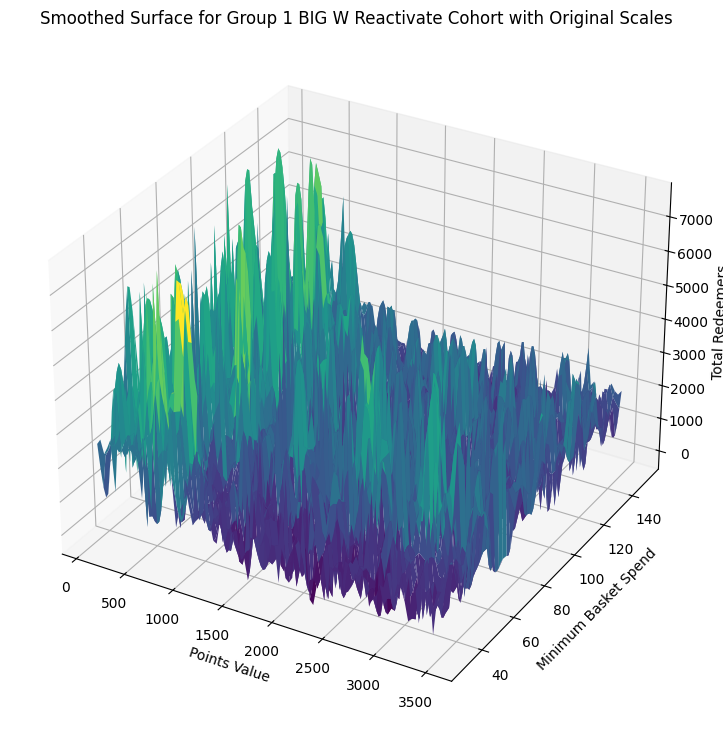

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.interpolate import griddata

# Assume df_combinations is your DataFrame 
filtered_df = df_combinations[df_combinations['CustomerSegment'] == 'Reactivate']

points = filtered_df[['points_value', 'minimum_basket_spend']].values
values = filtered_df['pred_Redeemers'].values

# Apply PCA
pca = PCA(n_components=2)
points_reduced = pca.fit_transform(points)

# Create grid values for interpolation
grid_x, grid_y = np.mgrid[
    points_reduced[:,0].min():points_reduced[:,0].max():100j, 
    points_reduced[:,1].min():points_reduced[:,1].max():100j
]

# Interpolate the values
grid_z = griddata(points_reduced, values, (grid_x, grid_y), method='cubic')

# Inverse transform the grid back to original space
grid_original = pca.inverse_transform(np.c_[grid_x.ravel(), grid_y.ravel()])
grid_x_orig, grid_y_orig = grid_original[:, 0].reshape(grid_x.shape), grid_original[:, 1].reshape(grid_y.shape)

# Plotting the surface with original scales
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Surface plot in original scale
ax.plot_surface(
    grid_x_orig, grid_y_orig, grid_z, cmap='viridis', edgecolor='none'
)

ax.set_xlabel('Points Value')
ax.set_ylabel('Minimum Basket Spend')
ax.set_zlabel('Total Redeemers')
ax.set_title('Smoothed Surface for Group 1 BIG W Reactivate Cohort with Original Scales')

plt.show()


In [22]:
import numpy as np
import plotly.graph_objs as go
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Assuming points_reduced, values, pca, grid_x, and grid_y are already defined

# Interpolate the values
grid_z = griddata(points_reduced, values, (grid_x, grid_y), method='cubic')

# Inverse transform the grid back to original space
grid_original = pca.inverse_transform(np.c_[grid_x.ravel(), grid_y.ravel()])
grid_x_orig, grid_y_orig = grid_original[:, 0].reshape(grid_x.shape), grid_original[:, 1].reshape(grid_y.shape)

# Create the interactive plot using Plotly
fig = go.Figure(data=[go.Surface(
    x=grid_x_orig,
    y=grid_y_orig,
    z=grid_z,
    colorscale='Viridis'
)])

# Update plot layout
fig.update_layout(
    title='Smoothed Surface for Group 1 BIG W Reactivate Cohort with Original Scales',
    scene=dict(
        xaxis_title='Points Value',
        yaxis_title='Minimum Basket Spend',
        zaxis_title='Total Redeemers'
    ),
    autosize=True,
    width=800,
    height=800,
    margin=dict(l=65, r=50, b=65, t=90)
)

# Show the plot
fig.show()

In [2]:
%pip install sqlfluff

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/833.0 kB ? eta -:--:--
   ---------------------------------------- 833.0/833.0 kB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pickle
import types

# Function to check if an object is serializable
def is_serializable(obj):
    try:
        pickle.dumps(obj)
    except (pickle.PicklingError, AttributeError, TypeError):
        return False
    return True

# Get a dictionary of all global variables, excluding non-serializable objects
variables = {k: v for k, v in globals().items() if not k.startswith('__') and k != 'pickle' and k != 'variables' and is_serializable(v)}

# Save all variables to a pickle file
with open('all_variables.pkl', 'wb') as file:
    pickle.dump(variables, file)

print("All serializable variables saved successfully!")



All serializable variables saved successfully!


In [24]:
import dill as pickle

# To load the variables back (in a new session)
with open('all_variables.pkl', 'rb') as file:
    loaded_variables = pickle.load(file)

for name, value in loaded_variables.items():
    print(f"{name} = {value}")

_ih = ['', '## switch to python to do the rest of the analysis\n\n# required \nimport pandas as pd\nimport numpy as np\nfrom google.cloud import bigquery\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.ensemble import GradientBoostingRegressor\nfrom xgboost import XGBRegressor\nimport matplotlib.pyplot as plt\nfrom itertools import product\nfrom sklearn.preprocessing import StandardScaler\nimport pandas_gbq\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D', '# Initialize BigQuery client\nclient = bigquery.Client(project=\'gcp-wow-rwds-ai-pobe-dev\')\n\n# Query\nsql = """\nSELECT * \nFROM `gcp-wow-rwds-ai-pobe-dev.angus.bigw_xmas_modelData2` \n"""\n\n# Execute query and get results as DataFrame\nmodelData = client.query(sql).to_dataframe()\n\n# Dataset Summary\n\n# 1. Column Headers\nprint("Column Headers:")\nprint(modelData.columns.tolist())\n\n# 2. Data Types\nprint("\\nData Types:")\nprint(modelData.dtypes)\n\n# 3. Missing Values\nprint("\\nMiss